In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

%matplotlib inline
%reload_ext autoreload

## Read the dataset

In [2]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons

(832, 832, 3)


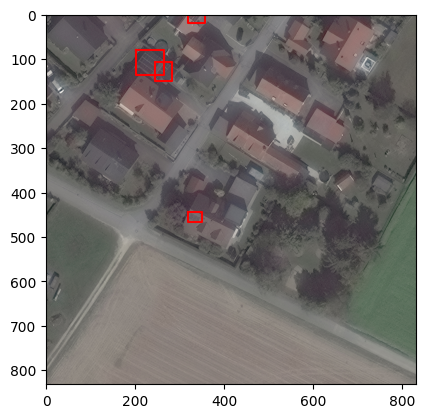

In [3]:
file = os.listdir('germany_dataset/labels')[0]
image, polygons = load_image_and_labels(file)

print(image.shape)

# Plot the image with the polygons drawn in
def plot_image_and_labels(image, polygons):
    # Convert the image to a numpy array
    image = np.array(image)

    for polygon in polygons:
        x, y = polygon.exterior.xy
        plt.plot(x, y, c='r')
        
    # Plot the image
    plt.imshow(image)
    plt.show()
    
plot_image_and_labels(image, polygons)

In [4]:
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

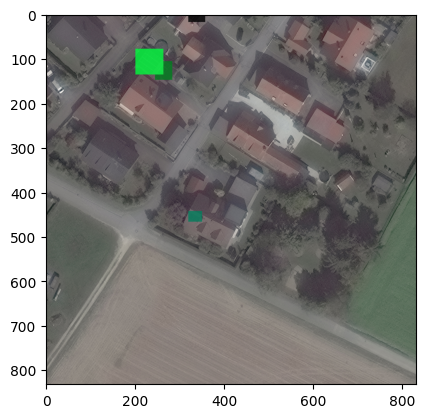

In [8]:
# Plot the mask and the images in the same plot
masks = polygons_to_masks(polygons)

def plot_image_and_mask(image, masks):
    # Convert the image to a numpy array
    image = torch.tensor(image, dtype=torch.uint8).permute(2, 0, 1)

    # Convert the masks to a tensor
    masks = torch.stack(masks)
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    
plot_image_and_mask(image, masks)


### Load the dataset

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataloaders.germany_dataset import GermanyDataset

In [ ]:
# From the dataset, create a train and test set
dataset = os.listdir('germany_dataset/labels')

train, test = train_test_split(dataset, test_size=0.2)

train_dataset = GermanyDataset(train)
test_dataset = GermanyDataset(test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Train the model

In [ ]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [ ]:
# model = DeepLabModel(input_size=832, num_classes=2)
# model = UNetModel(n_channels=3, n_classes=1)

model = MaskRCNNModel(num_classes=1)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

base_model = BaseModel(model, loss_fn, optimizer)
trainer = pl.Trainer(max_epochs=10, min_epochs=5)

In [ ]:
for image, label in train_loader:
    # Print the size of the image and label
    print(image.size(), label)  
    break

In [ ]:
trainer.fit(base_model, train_loader)

In [ ]:
# Estimate the model on the test set
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        output = model(image)
                
        # Convert the output to a polygon
        polygons = []
        for mask in output["masks"]:
            polygons.extend(mask_to_polygons(mask.numpy()))
        
        # Reshape image into 832x832
        image = image.view(832, 832, 3)
        
        # Plot the image and the polygons
        plot_image_and_labels(image, polygons)
        
        break
        